### Notebook for the cell proportion analysis of Mixed cell states in Healthy_vs_COPD CTRL_vs_IAV data

- **Developed by**: Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius Maximilian Universität Würzburg**
- **Created on**: 231204
- **Last modified**: 231204

### Load required packages

In [1]:
import milopy
import numpy as np
import pandas as pd
import scanpy as sc
import milopy.core as milo
import matplotlib.pyplot as plt

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                 10.1.0
appnope             0.1.3
asttokens           NA
cffi                1.16.0
comm                0.2.0
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.0
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
get_annotations     NA
h5py                3.10.0
importlib_resources NA
ipykernel           6.27.1
ipywidgets          8.1.1
jedi                0.19.1
jinja2              3.1.2
joblib              1.3.2
kiwisolver          1.4.5
llvmlite            0.41.1
markupsafe          2.1.3
matplotlib          3.8.2
milopy              0.1.1
mpl_toolkits        NA
natsort             8.4.0
numba               0.58.1
numpy               1.26.2
packaging           23.2
pandas              2.1.3
parso               0.8.3
patsy               0.5.4
pexpect             4.9.0
platformdirs        4.0.0
prompt_toolkit      3.0.41
psutil              5

### Load working object

In [3]:
adata_all = sc.read_h5ad('../../../data/Marburg_cell_states_locked_scANVI_ctl230901.raw.h5ad')
adata_all

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

### Subset population of interest

In [4]:
adata_all.obs['cell_type'].cat.categories

Index(['ciliated', 'club', 'basal', 'goblet', 'mixed'], dtype='object')

In [5]:
adata = adata_all[adata_all.obs['cell_type'].isin(['basal'])]
adata

View of AnnData object with n_obs × n_vars = 43045 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [6]:
adata.obs['batch'].cat.categories

Index(['CHE01_CTRL', 'CHE01_IAV', 'CHE02_CTRL', 'CHE02_IAV', 'CHE03_CTRL',
       'CHE03_IAV', 'CSE03_CTRL', 'CSE03_IAV', 'CSE_06_CRTL', 'CSE_06_IAV',
       'GER02_CTRL', 'GER02_IAV', 'GER12_CTRL', 'GER12_IAV', 'GER14_CRTL',
       'GER14_IAV', 'GnR08_CTRL', 'GnR08_IAV', 'GnR_07_CTRL', 'GnR_07_IAV',
       'ST07_CSE_CTRL', 'ST08_GnR_CTRL', 'ST09_CSE_IAV', 'ST10_GnR_IAV'],
      dtype='object')

### Build k-NN graph

In [7]:
sc.pp.neighbors(adata, n_neighbors = 50, random_state = 1712, use_rep = 'X_scANVI')

computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)


### Construct neighbourhoods a lá `milo`

In [8]:
milo.make_nhoods(adata)
adata.obsm["nhoods"]

/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/milopy/core.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2.17810154 1.67699409 2.20567393 ... 2.1526916  1.97069776 2.15949845]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"]


<43045x3299 sparse matrix of type '<class 'numpy.float32'>'
	with 355294 stored elements in Compressed Sparse Row format>

In [9]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
338338-ST07_CSE_CTRL-V1,1,2.178102
504490-ST07_CSE_CTRL-V1,1,1.676994
472387-ST07_CSE_CTRL-V1,1,2.205674
660312-ST07_CSE_CTRL-V1,1,1.903283
44612-ST07_CSE_CTRL-V1,1,2.062853
...,...,...
13724985-CSE03_IAV-V6,1,2.322696
10631838-CSE03_IAV-V6,1,1.810778
2391176-CSE03_IAV-V6,1,2.152692
450452-CSE03_IAV-V6,1,1.970698


(array([  1.,   2.,   4.,  11.,  10.,   5.,  22.,  22.,  37.,  47.,  41.,
         35.,  70.,  65., 100.,  82.,  50., 109.,  93.,  91.,  81., 105.,
         49., 104.,  96.,  92.,  94.,  52.,  95.,  94.,  92.,  80.,  92.,
         41.,  83.,  75.,  78.,  60.,  34.,  55.,  52.,  54.,  64.,  40.,
         26.,  52.,  47.,  43.,  38.,  20.,  28.,  30.,  39.,  30.,  16.,
          9.,  20.,  24.,  13.,  22.,  17.,  12.,  11.,  11.,  11.,  15.,
          8.,  12.,  14.,   9.,   4.,   5.,   2.,   8.,   4.,   2.,   5.,
          4.,   4.,   6.,   3.,   2.,   2.,   0.,   1.,   0.,   1.,   1.,
          2.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   3.,   0.,   0.,
          1.]),
 array([ 51.        ,  52.81999969,  54.63999939,  56.45999908,
         58.27999878,  60.09999847,  61.91999817,  63.74000168,
         65.55999756,  67.37999725,  69.19999695,  71.01999664,
         72.83999634,  74.66000366,  76.48000336,  78.30000305,
         80.12000275,  81.94000244,  83.76000214,  85.58000183

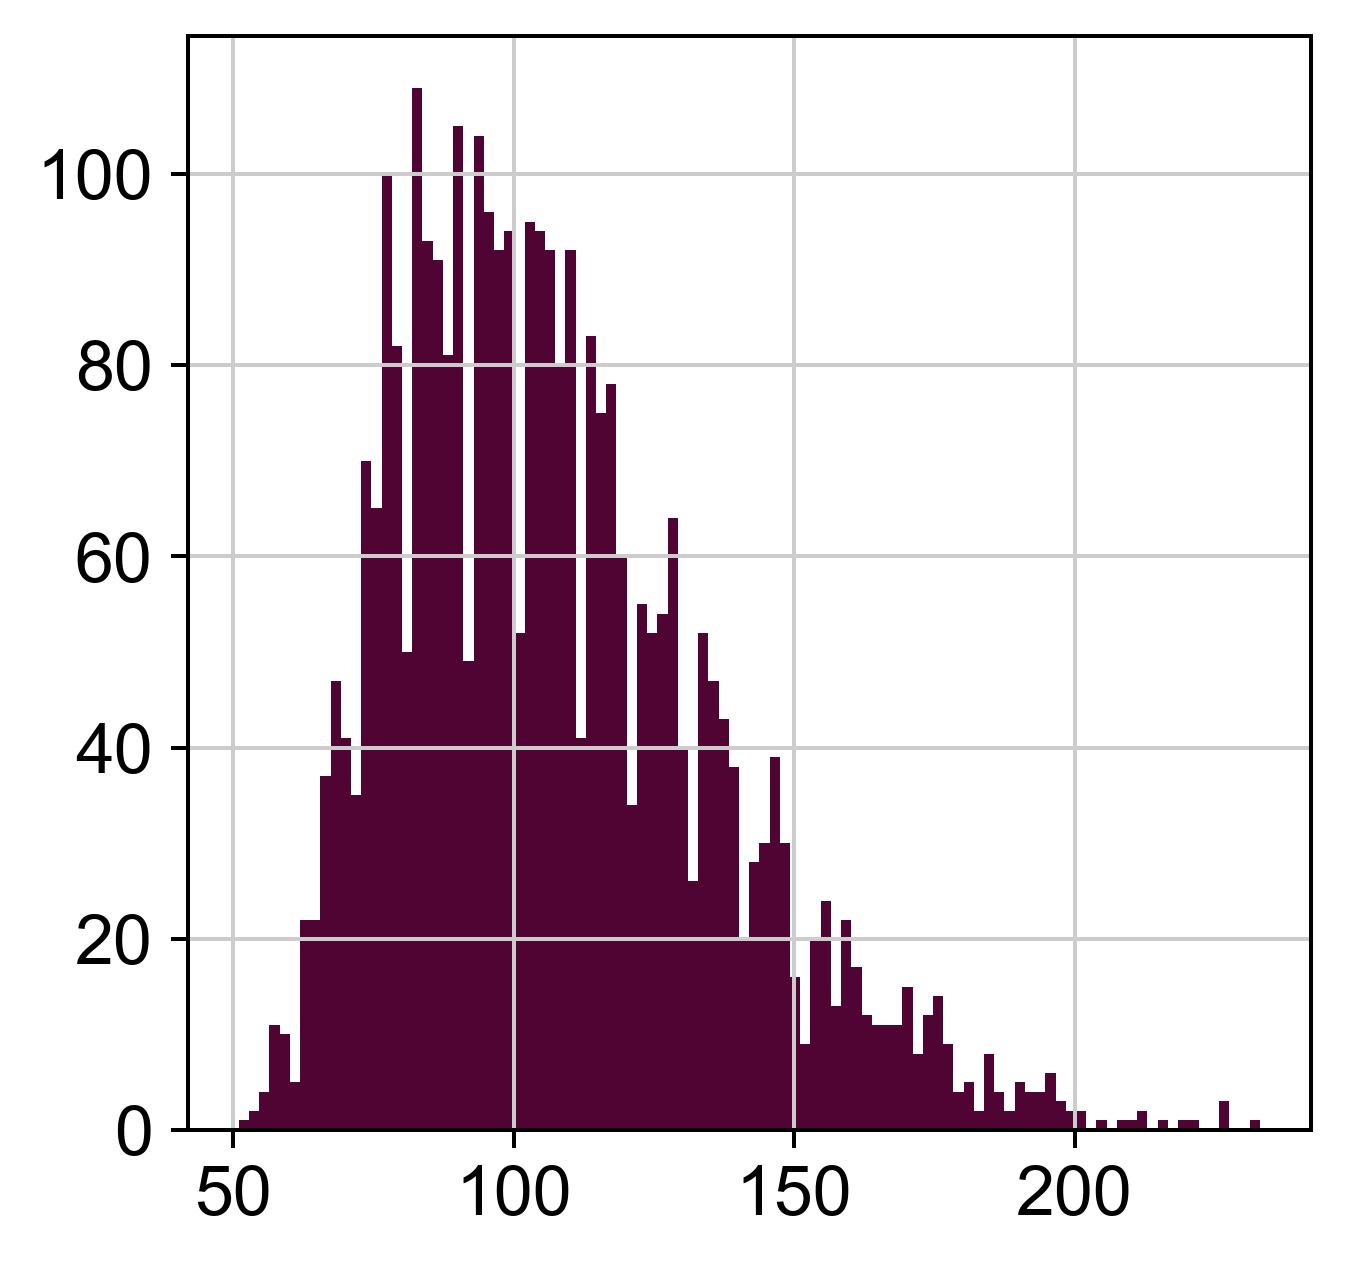

In [10]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins = 100, color = '#4F0433')

### Count cells in neighbourhoods

In [11]:
milo.count_nhoods(adata, sample_col = "batch")
adata.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 3299 × 24
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

### Differential abundance testing with GLM

In [12]:
milo.DA_nhoods(adata, design = "~ group")
adata.uns["nhood_adata"].obs

/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/milopy/core.py:239: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if design_df.dtypes[i].name == 'category':
/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/milopy/core.py:311: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/milopy/core.py:312: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a v

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,338338-ST07_CSE_CTRL-V1,2.178102,-0.964534,8.517654,0.776041,0.380295,0.570270,0.574333
1,504490-ST07_CSE_CTRL-V1,1.676994,-1.327660,8.566480,1.801465,0.182061,0.346779,0.350568
2,472387-ST07_CSE_CTRL-V1,2.205674,-3.084029,8.842008,5.487287,0.020973,0.061666,0.062865
3,660312-ST07_CSE_CTRL-V1,1.903283,-2.267474,8.310399,4.812666,0.030172,0.083857,0.085379
4,44612-ST07_CSE_CTRL-V1,2.062853,-1.067792,8.484437,1.084731,0.299729,0.484709,0.488899
...,...,...,...,...,...,...,...,...
3294,13724985-CSE03_IAV-V6,2.322696,4.580192,8.412628,14.816700,0.000191,0.001110,0.001144
3295,10631838-CSE03_IAV-V6,1.810778,0.747863,8.799065,0.530564,0.467784,0.651466,0.655146
3296,2391176-CSE03_IAV-V6,2.152692,-0.614554,8.363021,0.394225,0.531276,0.705256,0.708364
3297,450452-CSE03_IAV-V6,1.970698,-0.053619,8.390184,0.003032,0.956179,0.979580,0.980131


- Evaluate results

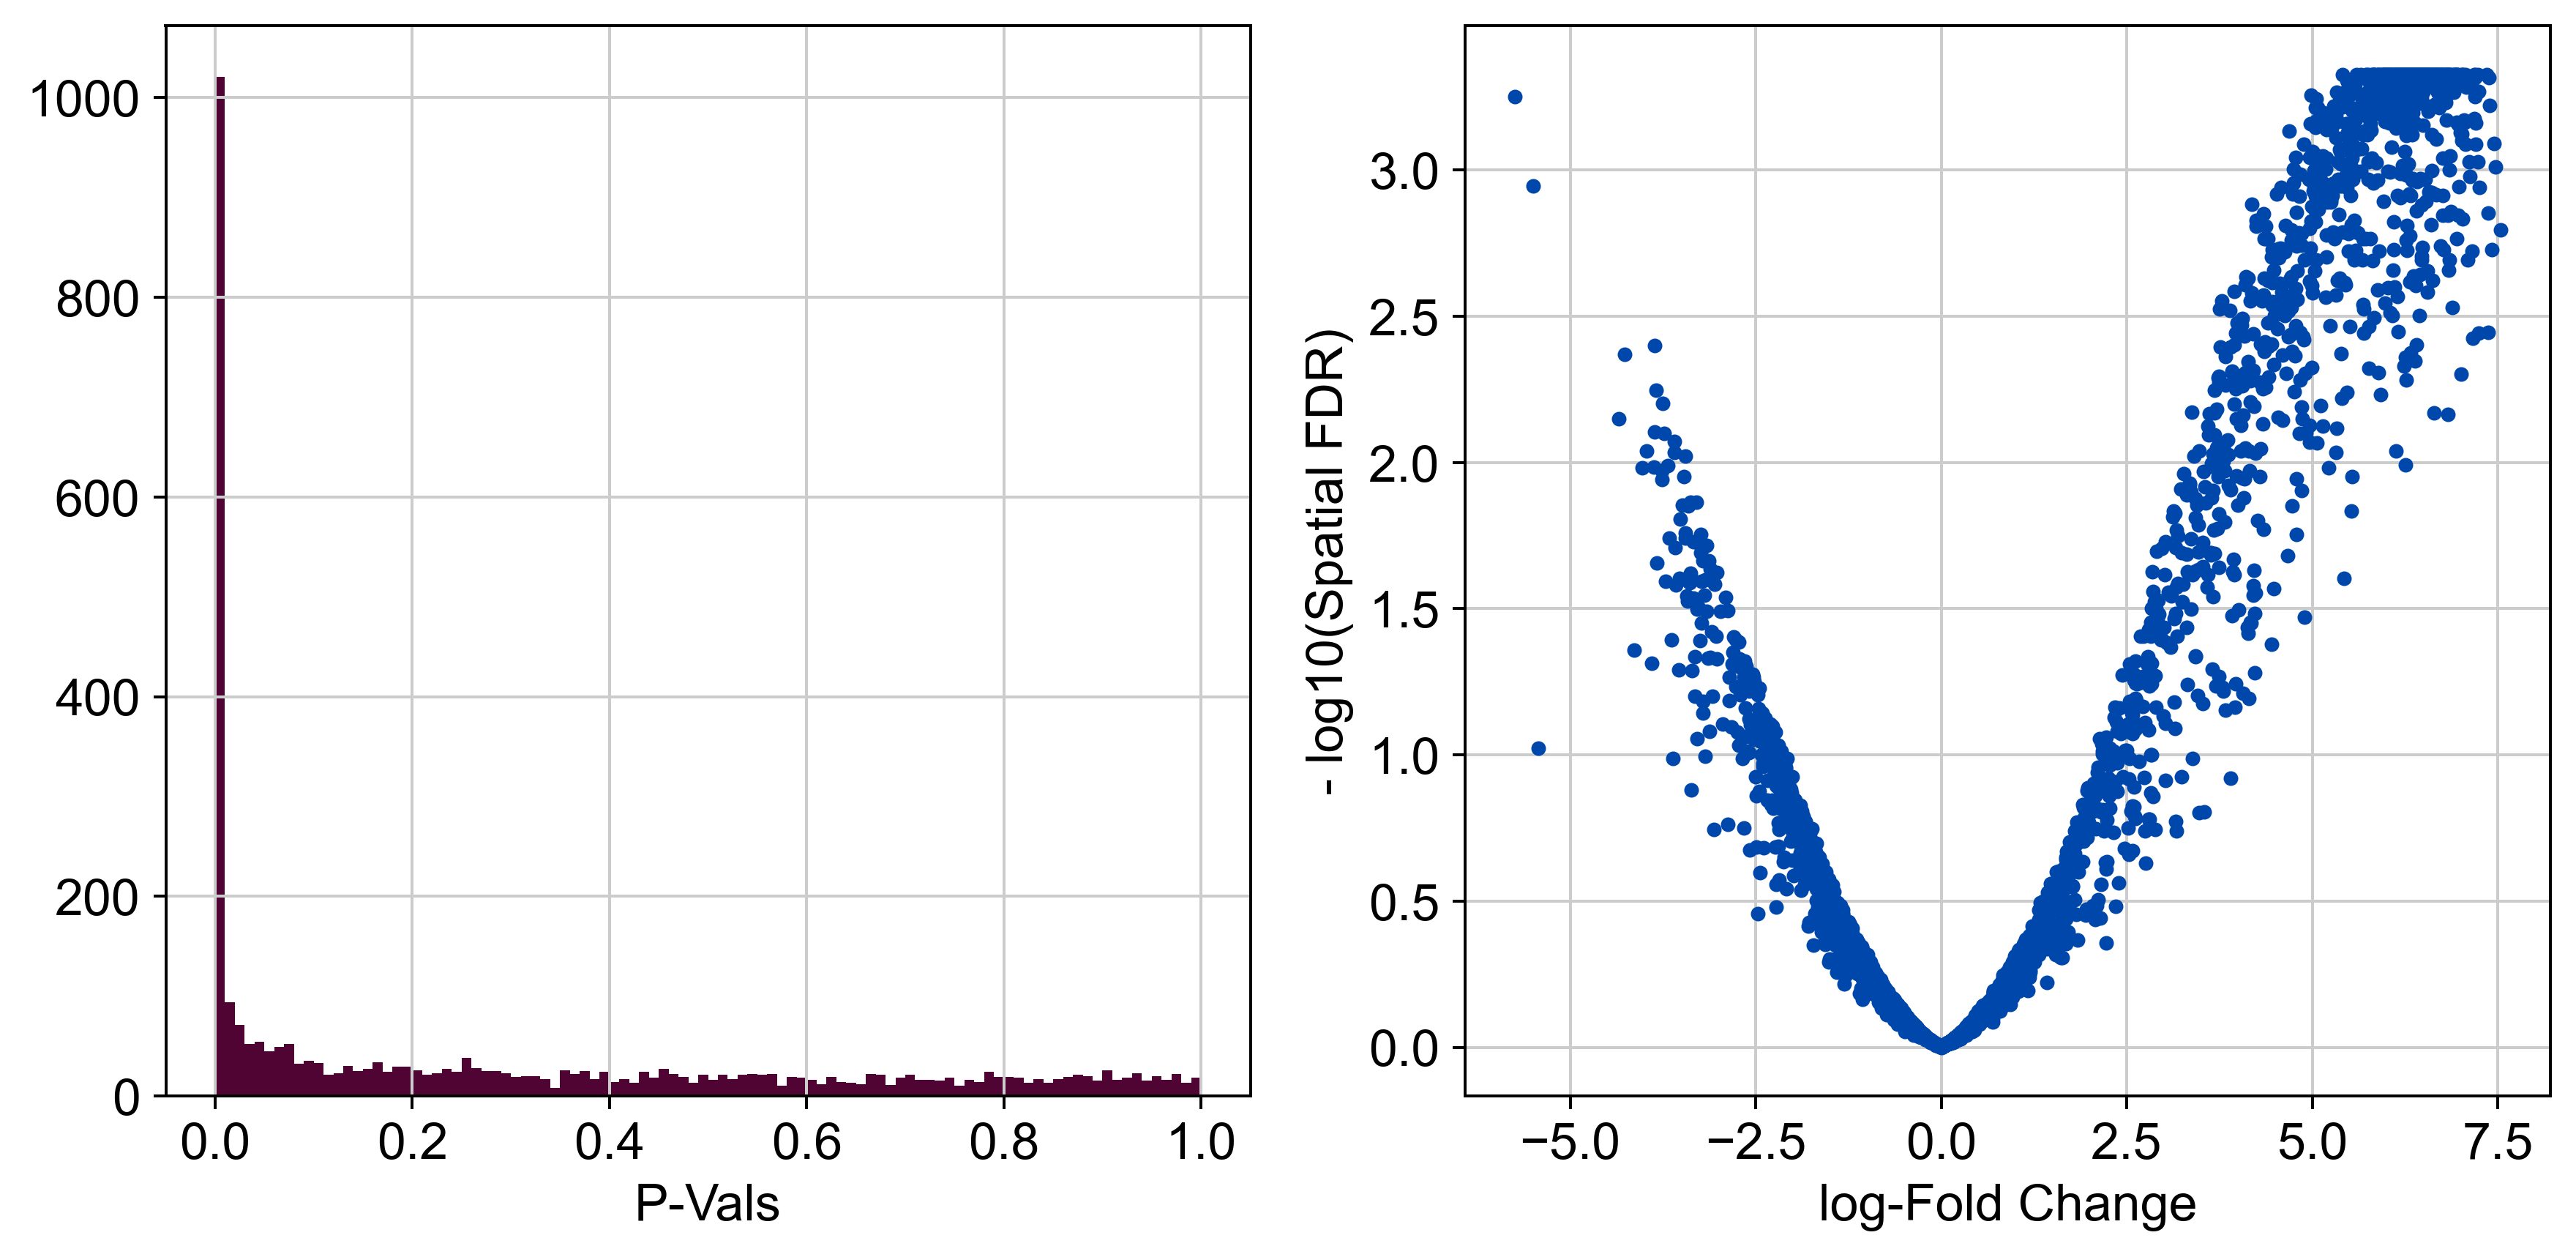

In [13]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins = 100, color = '#4F0433')
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.', color = '#0047AB')
plt.xlabel("log-Fold Change")
plt.ylabel("- log10(Spatial FDR)")
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [14]:
milo_results = adata.uns["nhood_adata"].obs
milo_results

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,338338-ST07_CSE_CTRL-V1,2.178102,-0.964534,8.517654,0.776041,0.380295,0.570270,0.574333
1,504490-ST07_CSE_CTRL-V1,1.676994,-1.327660,8.566480,1.801465,0.182061,0.346779,0.350568
2,472387-ST07_CSE_CTRL-V1,2.205674,-3.084029,8.842008,5.487287,0.020973,0.061666,0.062865
3,660312-ST07_CSE_CTRL-V1,1.903283,-2.267474,8.310399,4.812666,0.030172,0.083857,0.085379
4,44612-ST07_CSE_CTRL-V1,2.062853,-1.067792,8.484437,1.084731,0.299729,0.484709,0.488899
...,...,...,...,...,...,...,...,...
3294,13724985-CSE03_IAV-V6,2.322696,4.580192,8.412628,14.816700,0.000191,0.001110,0.001144
3295,10631838-CSE03_IAV-V6,1.810778,0.747863,8.799065,0.530564,0.467784,0.651466,0.655146
3296,2391176-CSE03_IAV-V6,2.152692,-0.614554,8.363021,0.394225,0.531276,0.705256,0.708364
3297,450452-CSE03_IAV-V6,1.970698,-0.053619,8.390184,0.003032,0.956179,0.979580,0.980131


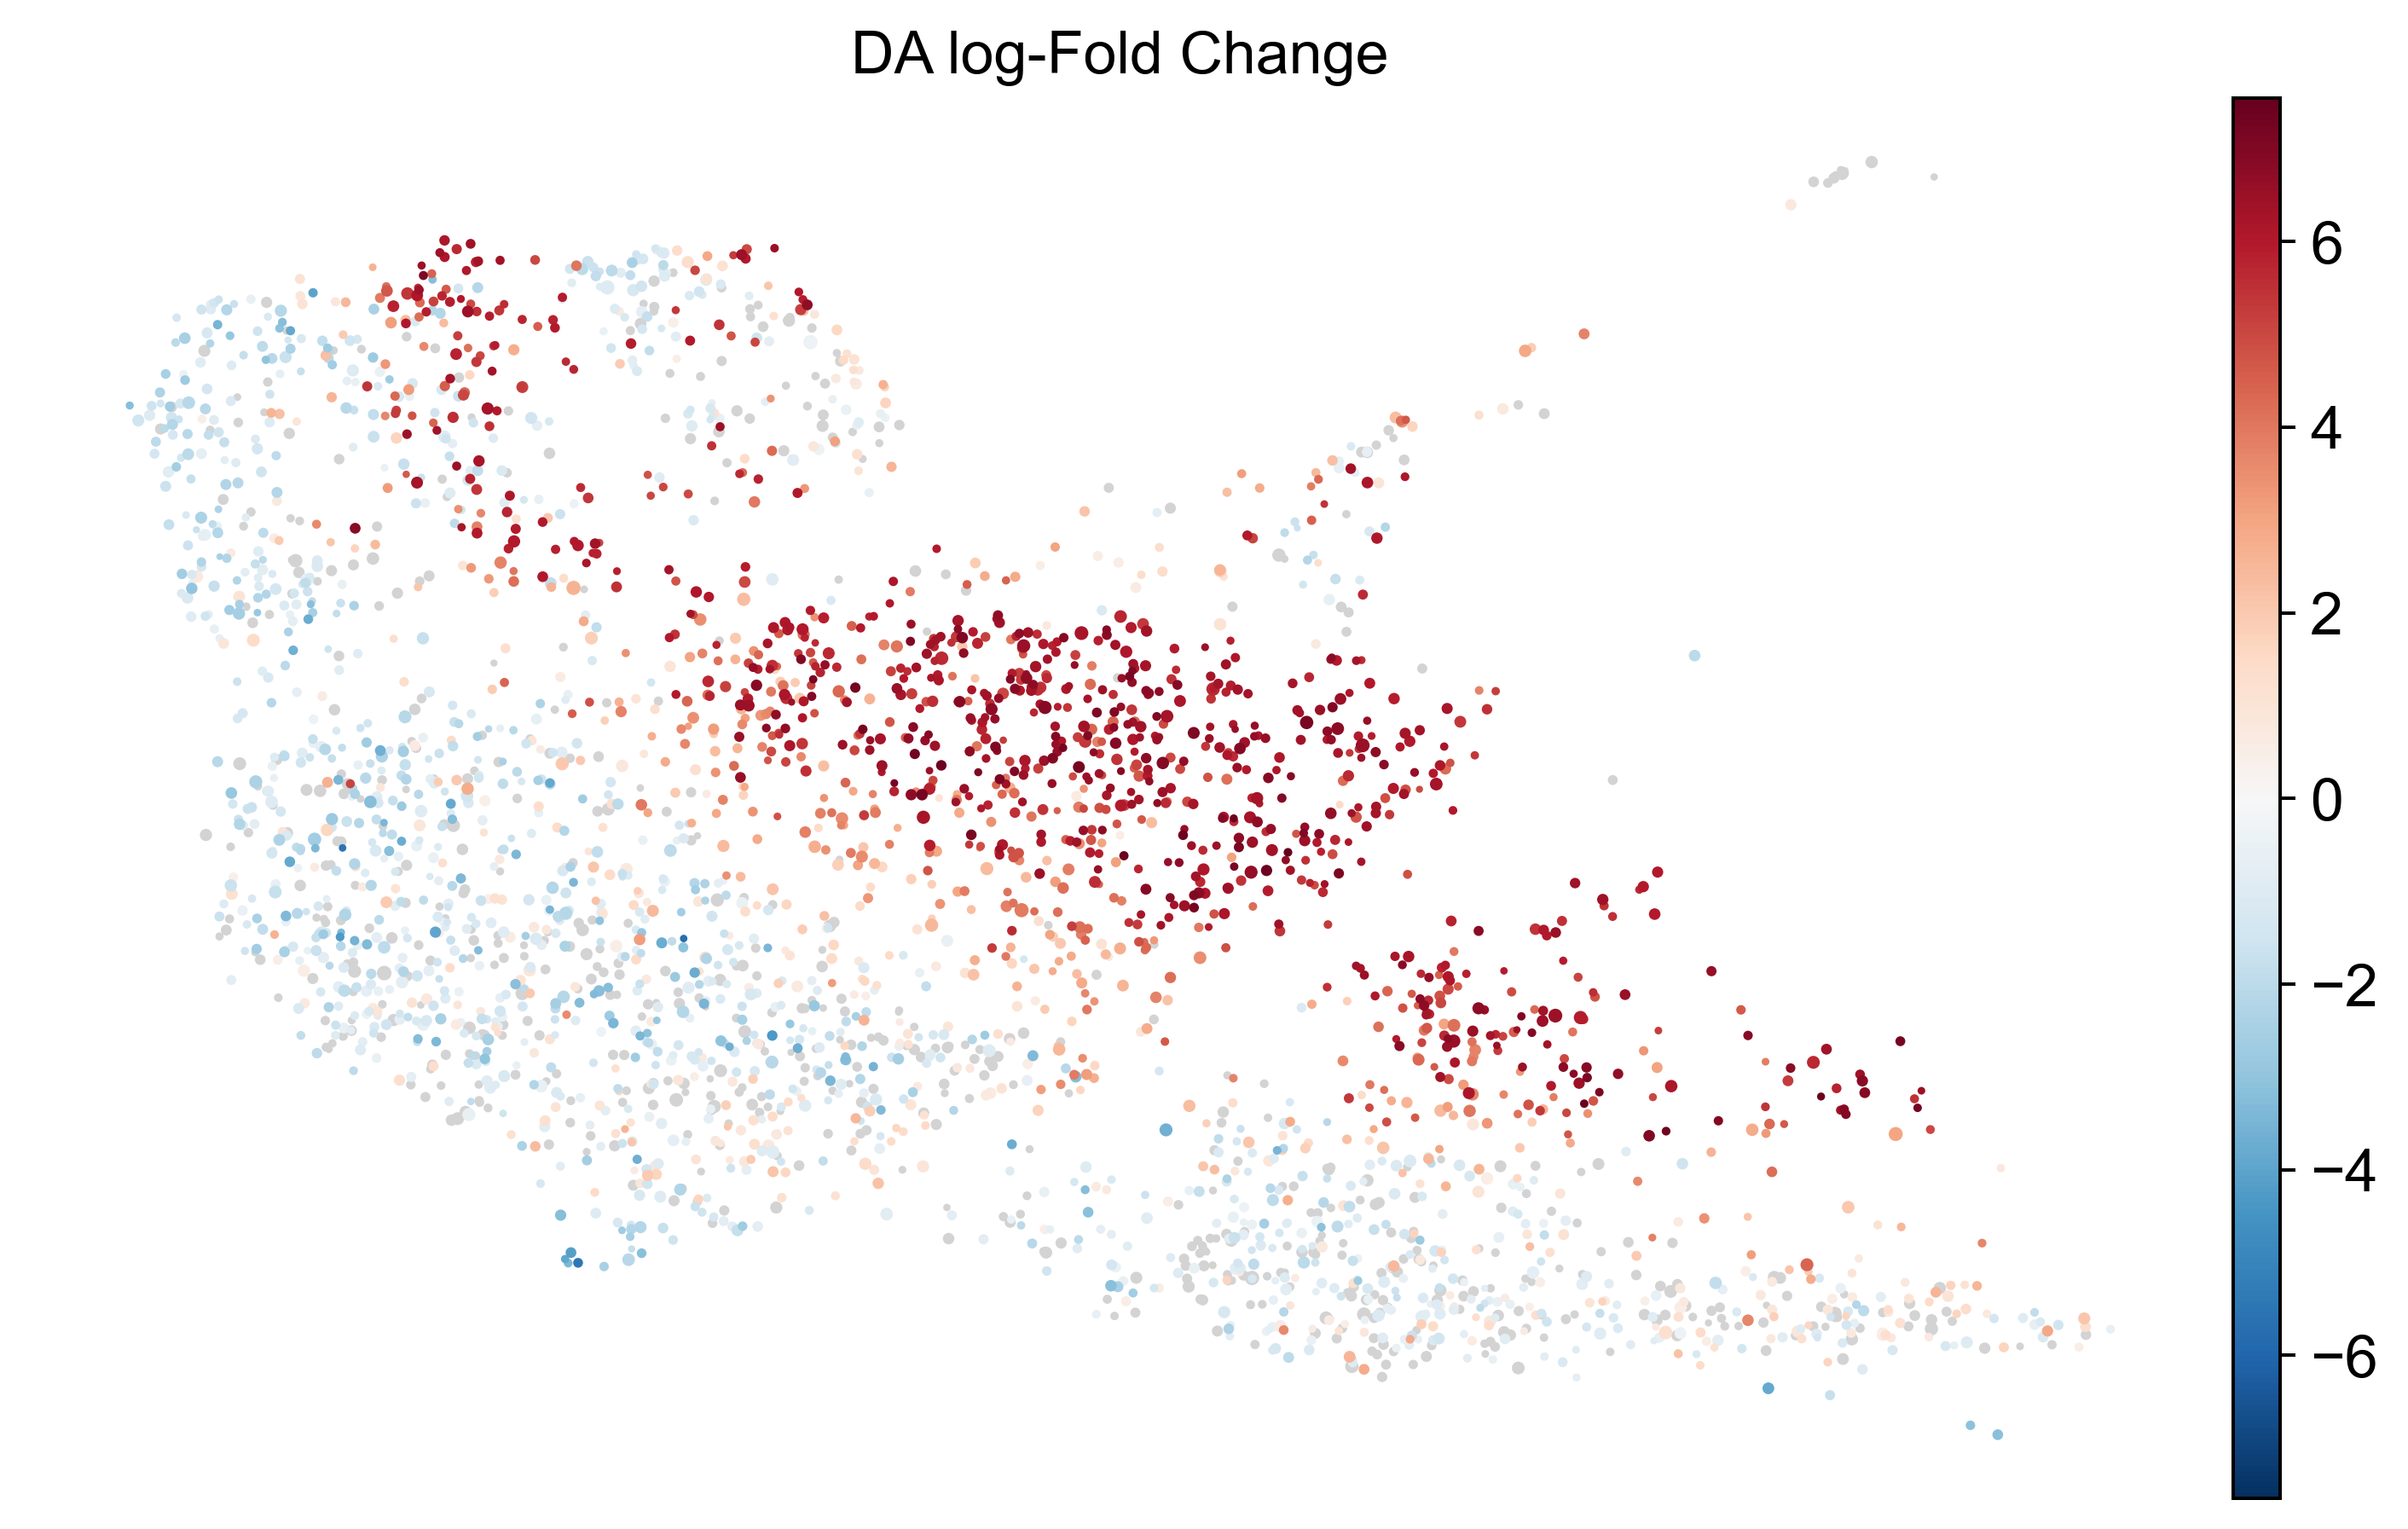

In [15]:
plt.rcParams["figure.figsize"] = [10,6]
milopy.utils.build_nhood_graph(adata)
milopy.plot.plot_nhood_graph(adata, alpha = 0.8, min_size = 0.2)

### Visualise results by cell type

In [16]:
milopy.utils.annotate_nhoods(adata, anno_col = 'cell_states')

Text(0.5, 0, 'cellstates fraction')

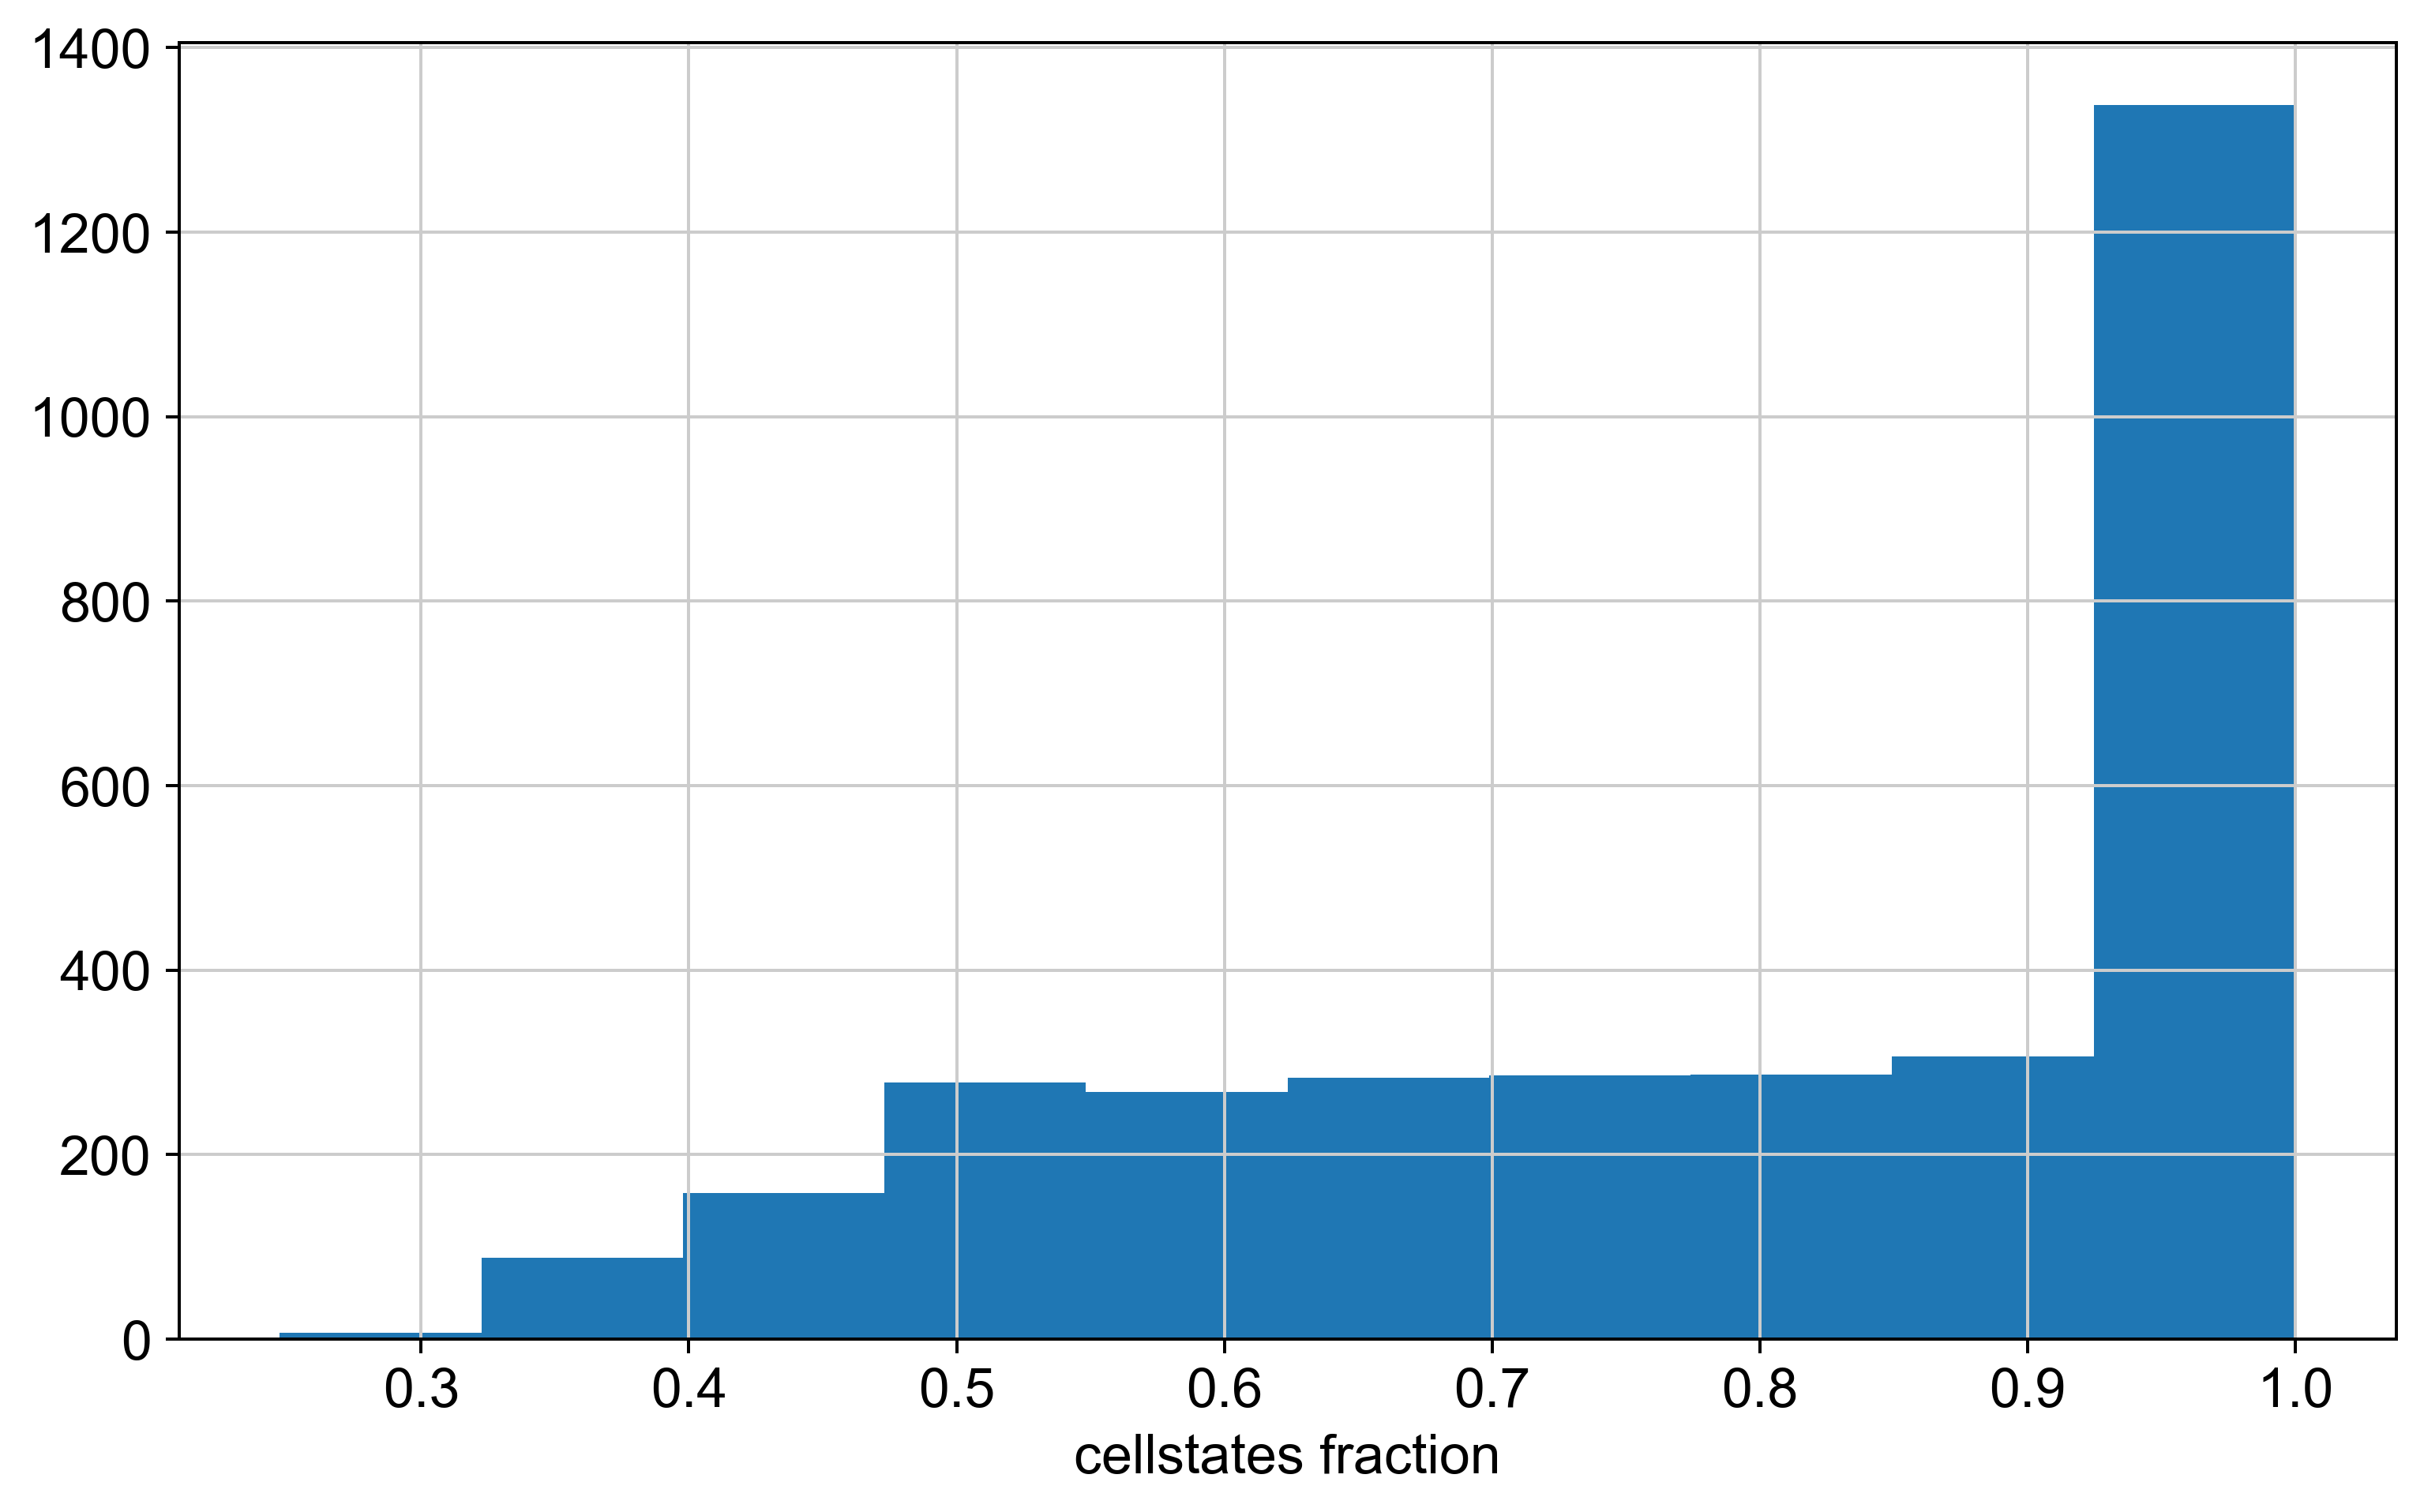

In [17]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"])
plt.xlabel("cellstates fraction")

In [18]:
nhood_annotation = adata.uns['nhood_adata'].obs['nhood_annotation']
nhood_annotation = nhood_annotation.cat.add_categories(['Ambiguous'])
adata.uns['nhood_adata'].obs['nhood_annotation'] = nhood_annotation

adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Ambiguous"


/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cartalop/mambaforge/envs/milopy/lib/python3.9/site-packages/sea

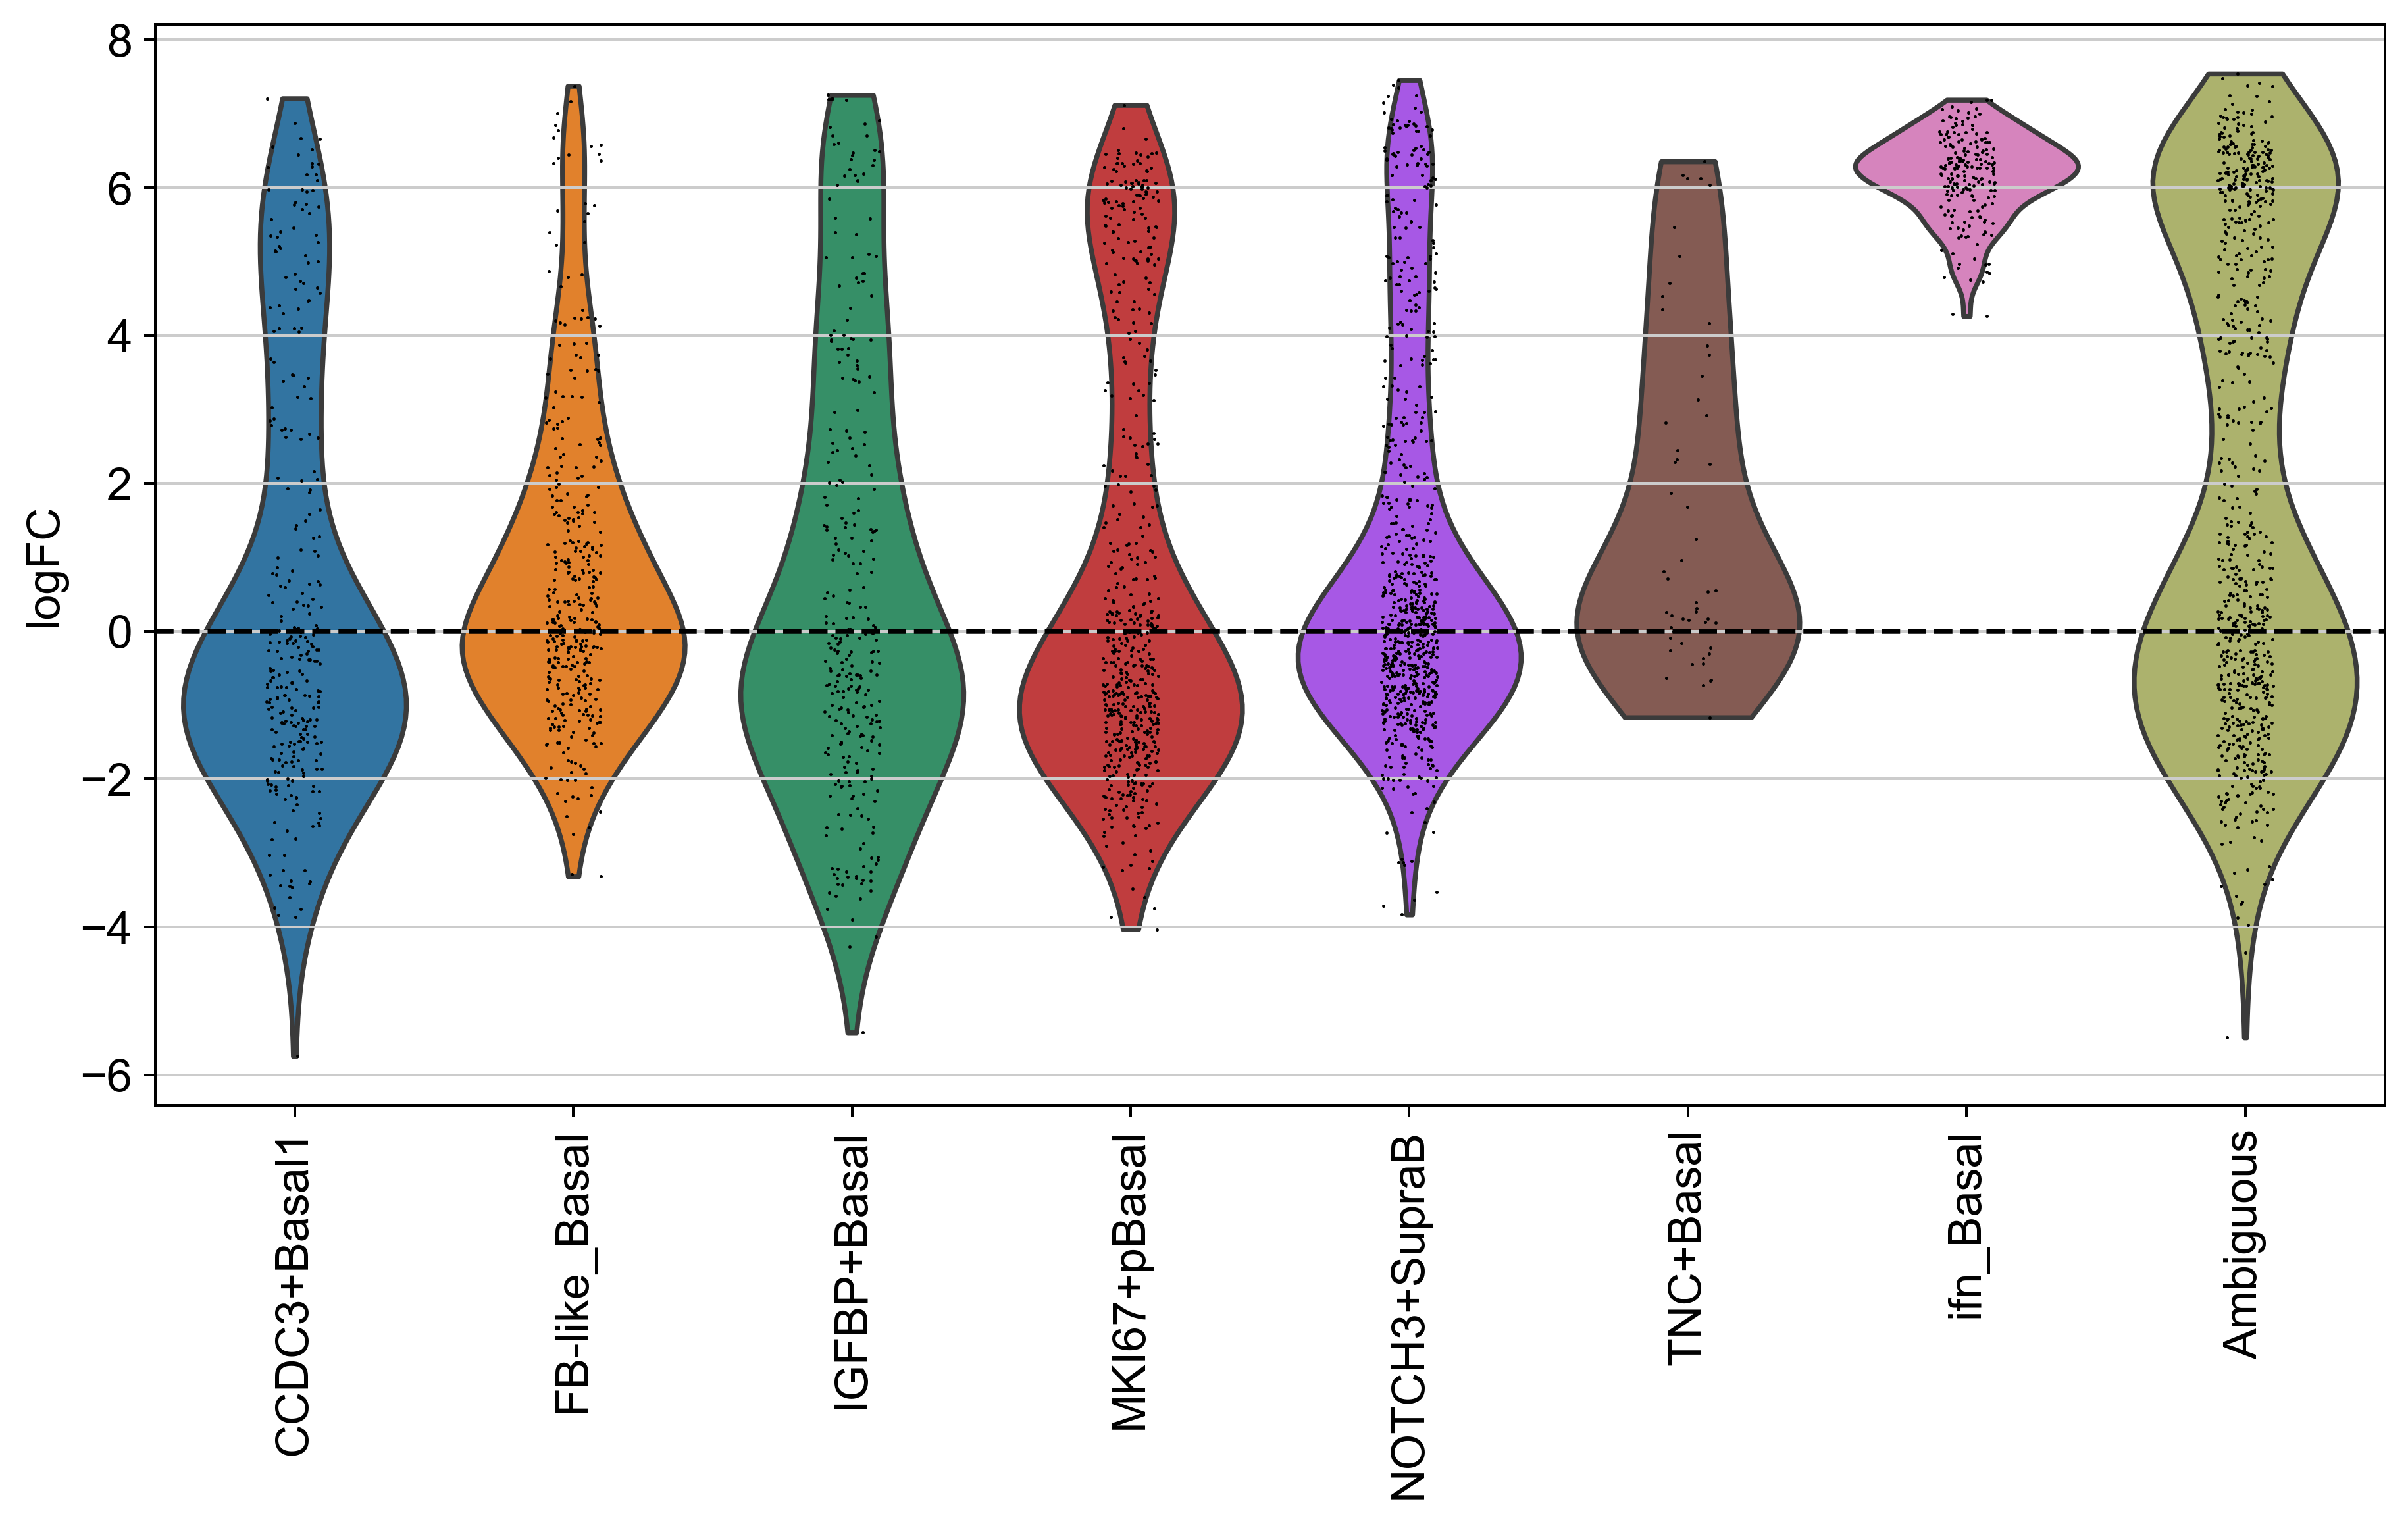

In [19]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby = "nhood_annotation", rotation = 90, show = False);
plt.axhline(y = 0, color = 'black', linestyle = '--');
plt.show()